<a href="https://colab.research.google.com/github/antoniodragoc/Projeto-de-Graduacao-Antonio-Drago-Caetano/blob/main/4_ResNet_50%2B(SVM_e_XGBoost).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Gerando os dados a partir das imagens
train_datagen = ImageDataGenerator(    
    rotation_range = 90,
    vertical_flip = True,
    horizontal_flip = True,
    zoom_range=0.05,
    width_shift_range=0.2,
		height_shift_range=0.2,
    fill_mode = 'reflect',
    samplewise_center = True,
    samplewise_std_normalization = True
)

val_datagen = ImageDataGenerator(
    samplewise_center = True,
    samplewise_std_normalization = True
    )


test_datagen = ImageDataGenerator(
    samplewise_center = True,
    samplewise_std_normalization = True
    )


In [ ]:

# Obs - no diretório dados4 os dados estão separados em 75% treino 15% validação e 10% teste
path_train = '/content/drive/MyDrive/PG/dados4/train/'
path_val = '/content/drive/MyDrive/PG/dados4/val/'

batch_size = 20

In [ ]:
# dados de treino
train_generator = train_datagen.flow_from_directory(
    path_train,
    target_size = (299, 299),
    batch_size= batch_size,
    shuffle=False,
    class_mode='categorical',
    seed = 123 
)

Found 300 images belonging to 4 classes.


In [ ]:
#dados de validação
val_generator = val_datagen.flow_from_directory(
    path_val,
    target_size = (299, 299),
    batch_size= batch_size,  
    shuffle=True,
    class_mode='categorical',
    seed = 123      
)

Found 60 images belonging to 4 classes.


In [ ]:
#dados de validação
test_datagen = ImageDataGenerator(
    samplewise_center = True,
    samplewise_std_normalization = True,
    )

In [ ]:
#dados de teste
path_test = '/content/drive/MyDrive/PG/dados4/test/'
test_generator =  test_datagen.flow_from_directory(
    path_test,
    target_size = (299, 299),
    shuffle = False,
    batch_size= batch_size,  
    class_mode='categorical' ,
    seed = 123     
    )

Found 40 images belonging to 4 classes.


In [ ]:
# lendo a rede salva

In [ ]:
checkpoint_path = '/content/drive/MyDrive/PG/codigo/checkpoint/'

new_model = tf.keras.models.load_model(checkpoint_path+'resnet0531')
new_model.load_weights(checkpoint_path)


In [ ]:
#Confution Matrix and Classification Report
Y_pred = new_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
cmresnet = confusion_matrix(test_generator.classes, y_pred )

In [ ]:
def confusion(cm):
  import seaborn as sns
  import matplotlib.pyplot as plt
  import numpy as np
  cm = cm
  fig, ax = plt.subplots(figsize=(12,12))
  sns.heatmap(cm, ax=ax, cbar=False, annot=True, fmt='d', cmap=plt.cm.Blues, linewidths=0.1)
  ax.set_xticklabels(['benign', 'insitu', 'invasive', 'normal']);
  ax.set_yticklabels(['benign', 'insitu', 'invasive', 'normal']);
  
  ax.set_ylabel('Classe Correta')
  ax.set_xlabel('Classe Prevista')

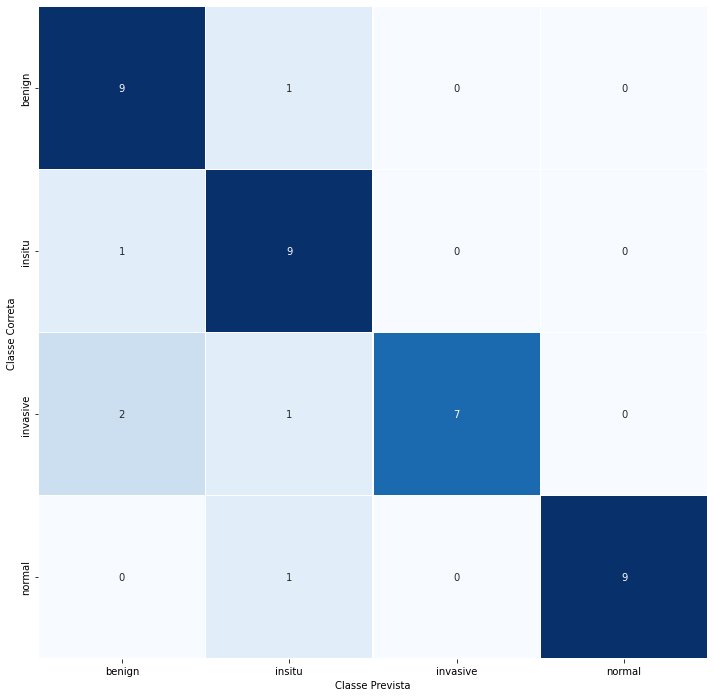

In [ ]:
confusion(cmresnet)

In [ ]:
test_generator

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int32)

In [ ]:
test_generator.class_indices

{'benign': 0, 'insitu': 1, 'invasive': 2, 'normal': 3}

In [ ]:
train_generator.class_indices

{'benign': 0, 'insitu': 1, 'invasive': 2, 'normal': 3}

In [ ]:
from keras.models import Model
model2= Model(inputs=new_model.input, outputs=new_model.layers[-5].output)
#model2.summary()

### PCA


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:
Y_pred = model2.predict(train_generator)

# Standardize features by removing the mean and scaling to unit variance.
standardizedData = StandardScaler().fit_transform(Y_pred)

# Variância de 95%
pca = PCA(n_components=0.95)
principalComponents = pca.fit(X = standardizedData)
#to get how much variance was retained
print(pca.explained_variance_ratio_.shape)
print(pca.explained_variance_ratio_.sum())

(269,)
0.95136863


In [ ]:
Y_pred.shape

(300, 204800)

In [ ]:
X_pca_train = pca.transform(standardizedData)

In [ ]:
clf = SVC()
clf.fit(X_pca_train, train_generator.classes)

SVC()

In [ ]:
X_test1 = model2.predict(test_generator)
standardizedData1 = StandardScaler().fit_transform(X_test1)

X_pca_test = pca.transform(standardizedData1)

In [ ]:
y_pca_pred = clf.predict(X_pca_test)

In [ ]:
# SVM antes do GridSearch
confusion_matrix(test_generator.classes, y_pca_pred )

array([[10,  0,  0,  0],
       [ 4,  4,  2,  0],
       [ 3,  0,  7,  0],
       [ 7,  0,  0,  3]])

In [ ]:
param_grid = {'C': [0.1, 0.5, 1, 2],
              'gamma': [0.1, 0.01, 0.0001, 0.00001],
              'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}

search = GridSearchCV(clf, param_grid = param_grid, n_jobs=-1)

In [ ]:
# https://scikit-learn.org/stable/modules/grid_search.html
search.fit(X_pca_train, train_generator.classes)

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1, 2],
                         'gamma': [0.1, 0.01, 0.0001, 1e-05],
                         'kernel': ['rbf', 'poly', 'sigmoid', 'linear']})

In [ ]:
# print best parameter after tuning
print(search.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(search.best_estimator_)

{'C': 1, 'gamma': 1e-05, 'kernel': 'sigmoid'}
SVC(C=1, gamma=1e-05, kernel='sigmoid')


In [ ]:
search.best_estimator_

SVC(C=1, gamma=1e-05, kernel='sigmoid')

In [ ]:
Y_test1

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2,
       2, 2, 0, 2, 2, 2, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int32)

In [ ]:
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int32)

In [ ]:
test_generator.class_indices

{'benign': 0, 'insitu': 1, 'invasive': 2, 'normal': 3}

In [ ]:
#Confution Matrix and Classification Report
#Y_pred = new_model.predict(test_generator)
#y_pred = np.argmax(, axis=1)

# Matriz após o GridSearch - Parâmetros otimizados
confusion_matrix(test_generator.classes, Y_test1 )

array([[ 9,  1,  0,  0],
       [ 1,  9,  0,  0],
       [ 1,  2,  7,  0],
       [ 0,  0,  0, 10]])

In [ ]:
print(classification_report(test_generator.classes, Y_test1 ))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.75      0.90      0.82        10
           2       1.00      0.70      0.82        10
           3       1.00      1.00      1.00        10

    accuracy                           0.88        40
   macro avg       0.89      0.88      0.87        40
weighted avg       0.89      0.88      0.87        40



In [ ]:
train_generator.class_indices

{'benign': 0, 'insitu': 1, 'invasive': 2, 'normal': 3}

### XGBoost


In [ ]:
# https://www.kaggle.com/code/wongguoxuan/eda-pca-xgboost-classifier-for-beginners/notebook
# https://towardsdatascience.com/how-to-use-pca-tsne-xgboost-and-finally-bayesian-optimization-to-predict-the-price-of-houses-626dbaf242ae
# https://ghayward.github.io/Hayward_George_Data_Scientist_EDA_Modeling_UnsupervisedLearning_SQL.
# https://www.datageeks.com.br/xgboost/

In [ ]:
import xgboost as xgb
#from sklearn.metrics import mean_squared_error

In [ ]:
# We create the XGboost-specific DMatrix data format from the numpy array. 
# This data structure is optimised for memory efficiency and training speed
dtrain = xgb.DMatrix(X_pca_train, label=train_generator.classes)
#dvalid = xgb.DMatrix(valid_x_transform, label=valid_y)

In [ ]:

params = {
        'n_estimators': 200,
        'max_depth': 5 ,
        'learning_rate': 0.51,
        'subsample': 1 ,
        'colsample_bytree': 1 ,
        'gamma': 8 ,
        'tree_method': 'gpu_hist',  
        'objective': 'binary:logistic',
          }

xgboost = xgb.XGBClassifier(**params)
    
bst = xgboost.fit(X_pca_train, train_generator.classes)

Entender e implementar otimizador para o XGBoost

In [ ]:
data_dmatrix_test = xgb.DMatrix(data=X_pca_test)

In [ ]:
# https://github.com/dmlc/xgboost/issues/4582
# https://stackoverflow.com/questions/66794560/perform-incremental-learning-of-xgbclassifier

# Não precisa criar o DMatrix pq o modelo já aprendeu a fazer isso no treino.
preds = bst.predict(X_pca_test)

In [ ]:
preds

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2,
       2, 2, 0, 2, 2, 2, 1, 2, 3, 0, 3, 3, 3, 3, 0, 3, 3, 3], dtype=int32)

In [ ]:
y_pred = np.rint(preds)
confusion_matrix(test_generator.classes, preds )

array([[7, 2, 1, 0],
       [0, 7, 3, 0],
       [1, 2, 7, 0],
       [2, 0, 0, 8]])

In [ ]:
print(classification_report(test_generator.classes, preds ))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70        10
           1       0.64      0.70      0.67        10
           2       0.64      0.70      0.67        10
           3       1.00      0.80      0.89        10

    accuracy                           0.73        40
   macro avg       0.74      0.72      0.73        40
weighted avg       0.74      0.72      0.73        40



In [ ]:
print(bst.__dict__)

{'max_depth': 5, 'learning_rate': 0.51, 'n_estimators': 200, 'verbosity': 1, 'silent': None, 'objective': 'multi:softprob', 'booster': 'gbtree', 'gamma': 8, 'min_child_weight': 1, 'max_delta_step': 0, 'subsample': 1, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'colsample_bynode': 1, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'base_score': 0.5, 'missing': nan, 'kwargs': {'tree_method': 'gpu_hist'}, '_Booster': <xgboost.core.Booster object at 0x7f3eb766f150>, 'seed': None, 'random_state': 0, 'nthread': None, 'n_jobs': 1, 'importance_type': 'gain', 'classes_': array([0, 1, 2, 3], dtype=int32), 'n_classes_': 4, '_le': LabelEncoder(), '_features_count': 269}


In [ ]:
bst.classes_

array([0, 1, 2, 3], dtype=int32)

In [ ]:
test_generator.class_indices

{'benign': 0, 'insitu': 1, 'invasive': 2, 'normal': 3}

### XGBoost - Otimização


In [ ]:
#https://towardsdatascience.com/how-to-use-pca-tsne-xgboost-and-finally-bayesian-optimization-to-predict-the-price-of-houses-626dbaf242ae
#https://towardsdatascience.com/an-introductory-example-of-bayesian-optimization-in-python-with-hyperopt-aae40fff4ff0
#https://towardsdatascience.com/bayesian-optimization-with-python-85c66df711ec

In [ ]:
!pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
data_dmatrix_test = xgb.DMatrix(data=X_pca_test)

In [ ]:
from bayes_opt import BayesianOptimization

def fcv(max_depth, gamma, min_child_weight, subsample, colsample_bytree, learning_rate, num_boost_round):
  params = {"objective":'reg:squarederror', "max_depth":int(max_depth), 
            'gamma':gamma, 'min_child_weight':min_child_weight, 
            'subsample':subsample, "colsample_bytree":colsample_bytree, 
            "learning_rate":learning_rate,   
            }

  cv_results=xgb.cv(
      dtrain=dtrain, # Se atentar com o tipo de dados. Deve ser DMatrix
      params=params, nfold=10, 
      num_boost_round=int(num_boost_round), early_stopping_rounds=10, 
      metrics='rmse', as_pandas=True)
  
  return -cv_results['test-rmse-mean'].min() #any idea why I used a negative sign? Hint: it matters for the Bayesian Optimization function?

#Now, create a dictionary for the boundaries we should search within, and call
#the bayesian optimization function!
dict_cv = {
          'max_depth': (2, 10),
          'gamma': (0.001, 5),
          'min_child_weight': (5, 20),
          'subsample': (0.4, 1.0),
          'colsample_bytree': (0.4, 1.0),
          'learning_rate': (0.001, 1.0),
          'num_boost_round' :(10, 100)
          }

XGB_BO = BayesianOptimization(fcv, dict_cv) #Creating the optimizer
XGB_BO.maximize(init_points=5, n_iter=100, acq='ei', xi=0.0) #Running optimization!

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | num_bo... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -0.9706   |  0.5104   |  3.016    |  0.887    |  4.279    |  12.09    |  34.7     |  0.5427   |
|  2        | -0.6516   |  0.8748   |  0.5281   |  0.2742   |  6.575    |  14.93    |  58.63    |  0.9938   |
|  3        | -0.9244   |  0.815    |  2.655    |  0.805    |  8.259    |  16.97    |  29.92    |  0.6839   |
|  4        | -0.8075   |  0.9139   |  2.685    |  0.986    |  2.913    |  15.77    |  28.78    |  0.7696   |
|  5        | -0.7585   |  0.7109   |  2.649    |  0.2495   |  7.216    |  19.34    |  78.38    |  0.4664   |
|  6        | -0.6171   |  0.8545   |  0.7976   |  0.268    |  6.653    |  15.3     |  61.07    |  0.932    |
|  7        | -0.6178   |  1.0      |  0.001    |  0.1593   |  6.43     |  12.34    |  64.85    |  1.0      |
|  8      

In [ ]:
print("Best result: {}; f(x) = {}.".format(XGB_BO.max["params"], XGB_BO.max["target"]))

Best result: {'colsample_bytree': 1.0, 'gamma': 0.001, 'learning_rate': 0.16620829260583575, 'max_depth': 6.854183273066072, 'min_child_weight': 10.250102181163287, 'num_boost_round': 63.68940252175128, 'subsample': 1.0}; f(x) = -0.6045458.


In [ ]:
params =  {
    'colsample_bytree': 1.0, 'gamma': 0.001, 
    'learning_rate': 0.16620829260583575, 'max_depth': int(6.854183273066072), 
    'min_child_weight': 10.250102181163287, 'num_boost_round': 63.68940252175128, 
    'subsample': 1.0,
    'tree_method': 'gpu_hist',  
    'objective': 'binary:logistic',
}

In [ ]:
xgboost = xgb.XGBClassifier(**params)
    
bst = xgboost.fit(X_pca_train, train_generator.classes)

In [ ]:
# Não precisa criar o DMatrix pq o modelo já aprendeu a fazer isso no treino.
preds = bst.predict(X_pca_test)

In [ ]:
y_pred = np.rint(preds)
confusion_matrix(test_generator.classes, preds )

array([[7, 3, 0, 0],
       [1, 7, 2, 0],
       [1, 2, 7, 0],
       [2, 0, 0, 8]])

In [ ]:
m3 = confusion_matrix(test_generator.classes, preds )

In [ ]:
cmxgboost = confusion_matrix(test_generator.classes, preds )]
confusion(cmxgboost)

In [ ]:
print(classification_report(test_generator.classes, preds ))

              precision    recall  f1-score   support

           0       0.64      0.70      0.67        10
           1       0.58      0.70      0.64        10
           2       0.78      0.70      0.74        10
           3       1.00      0.80      0.89        10

    accuracy                           0.73        40
   macro avg       0.75      0.72      0.73        40
weighted avg       0.75      0.72      0.73        40



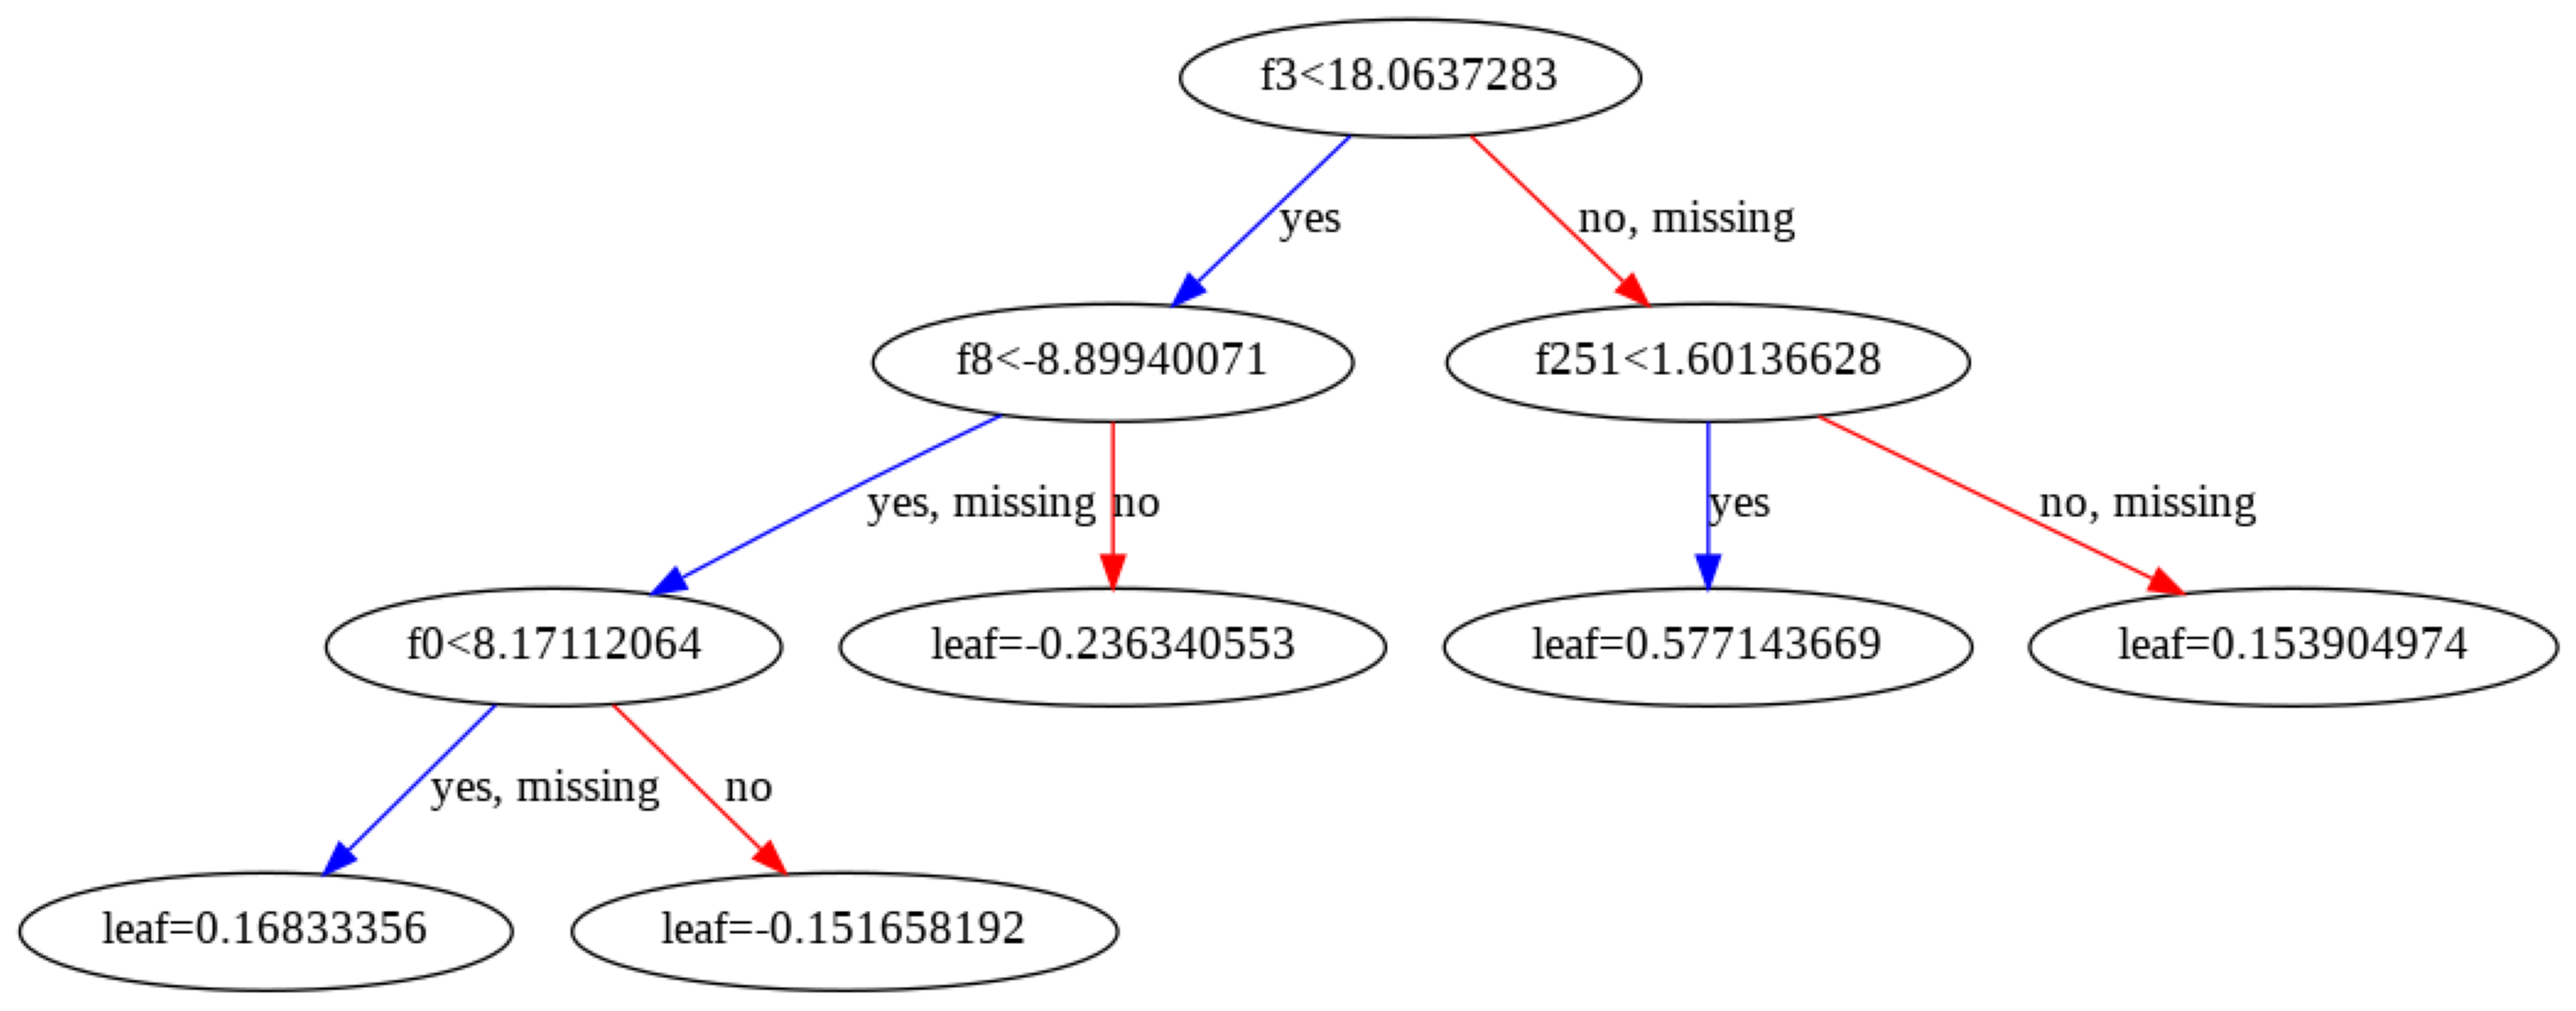

In [ ]:
import matplotlib.pyplot as plt

xgb.plot_tree(bst,num_trees=1)
#plt.rcParams['figure.figsize'] = [50, 50]
plt.show()